In [1]:
#-----Assignment-2 Question-3-----------
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from newsapi import NewsApiClient
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

In [2]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
# Download NLTK vader lexicon for sentiment analysis
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\alekh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# 1. Obtained News API Key: 
news_api_key = "454062c4e0c04528a932b3b9b1038ca1"
start_date = '2023-10-15'
end_date = '2023-11-15'
company_tickers = ["AAPL", "GOOGL", "MSFT"]  # Apple, Google, Microsoft

In [4]:
# Function to fetch stock data
def fetch_stock_data(symbol, start_date, end_date):
    return yf.download(symbol, start=start_date, end=end_date)

# Function to fetch news data
def fetch_news_data(api_key, query, from_date, to_date):
    newsapi = NewsApiClient(api_key=api_key)
    return newsapi.get_everything(q=query, from_param=from_date, to=to_date)

# Function for sentiment analysis
def analyze_sentiment(news):
    sia = SentimentIntensityAnalyzer()
    news['sentiment'] = news['content'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
    return news

# Merge and prepare data
def prepare_data(stock_data, news_data):
    
    # Preprocess and analyze news data
    news_df = pd.DataFrame.from_dict(news_data['articles'])
    analyzed_news = analyze_sentiment(news_df)
    
    # Prepare final dataset
    analyzed_news['publishedAt'] = pd.to_datetime(analyzed_news['publishedAt']).dt.date
    news_grouped = analyzed_news.groupby('publishedAt')['sentiment'].mean().reset_index()
    news_grouped.index = news_grouped['publishedAt']
    news_grouped.drop(['publishedAt'], axis=1, inplace=True)
    
    # Merge datasets
    merged_data = stock_data.join(news_grouped)
    merged_data = merged_data.fillna(0)
    
    return merged_data

[*********************100%%**********************]  1 of 1 completed


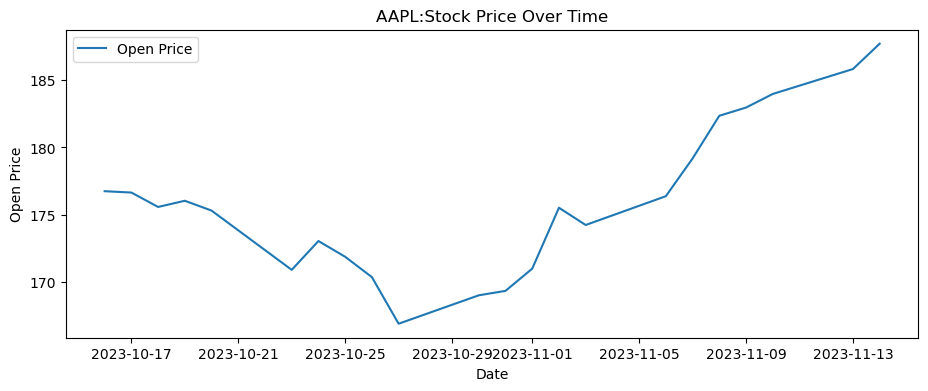

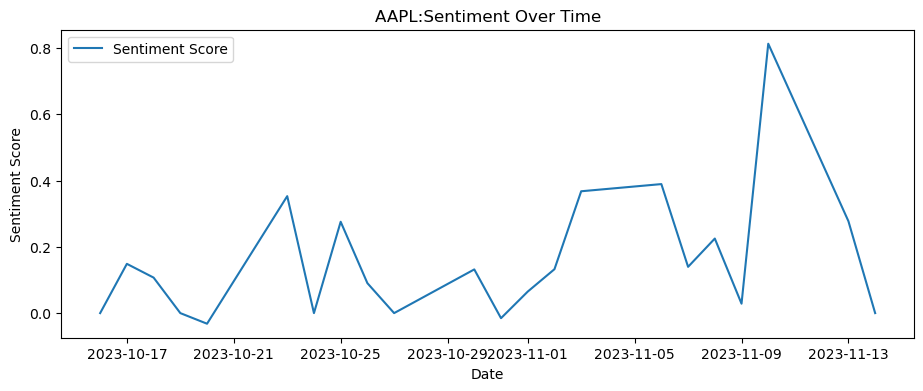

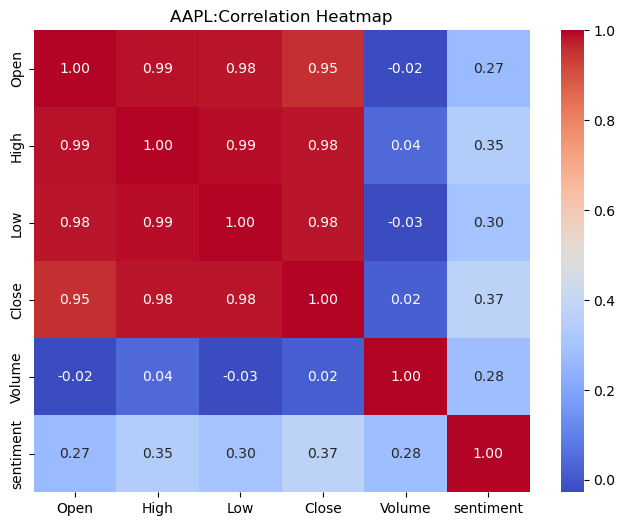

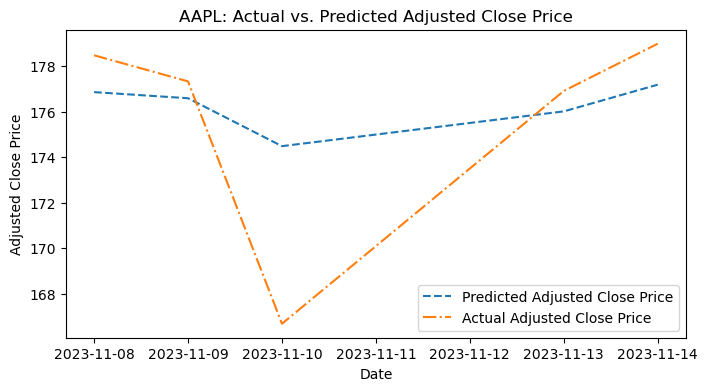

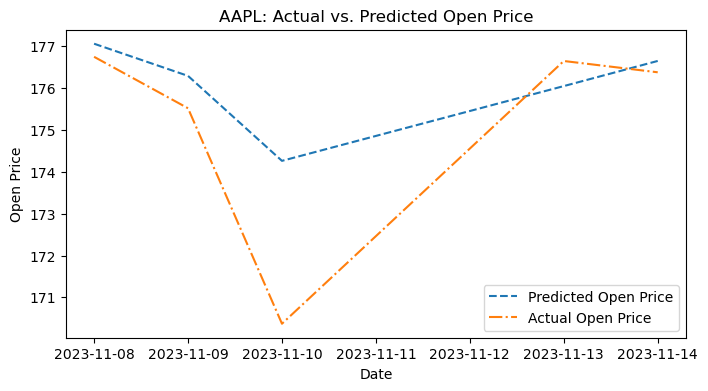


Results for AAPL:
Mean Absolute Error (MAE_Adj_Close): 2.5759622941023226
Mean Squared Error (MSE_Adj_Close): 13.663435743042873
R-squared (R^2_Adj_Close): 0.34497514093991166
 
Mean Absolute Error (MAE_Open): 1.170181897843446
Mean Squared Error (MSE_Open): 3.257534180124084
R-squared (R^2_Open): 0.4442388782611826


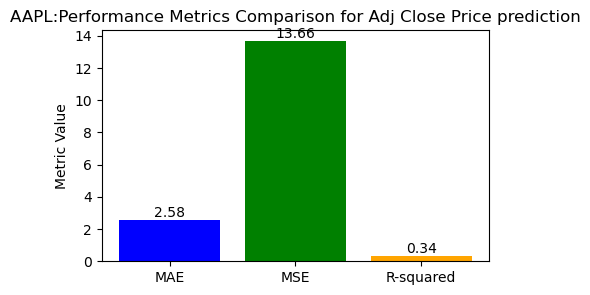

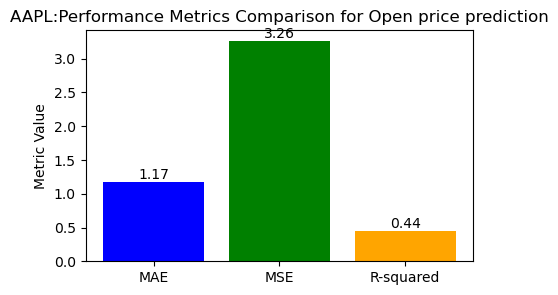

SVR Model saved as AAPL_svr_models.pkl
[*********************100%%**********************]  1 of 1 completed


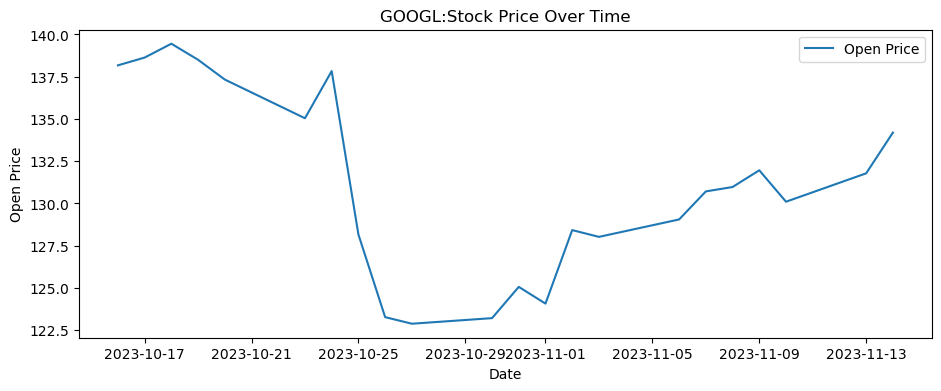

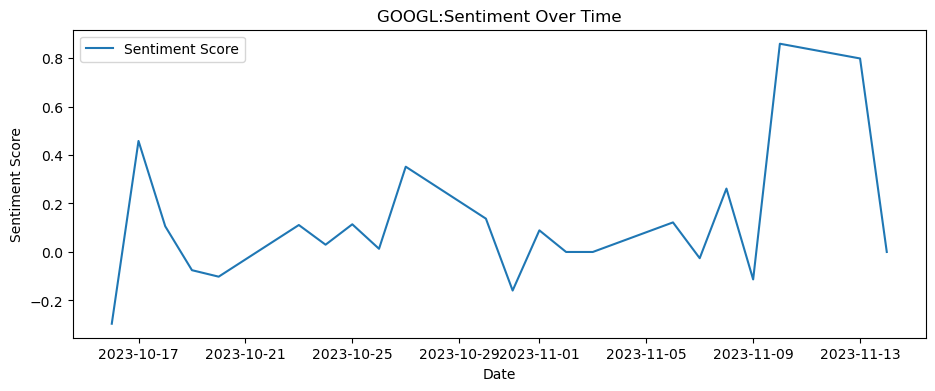

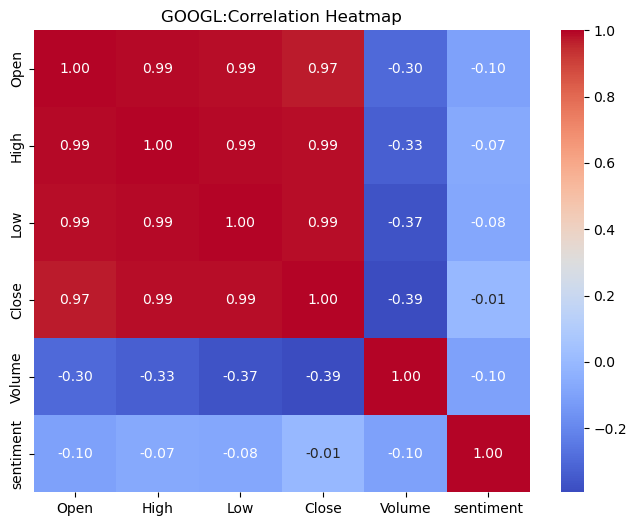

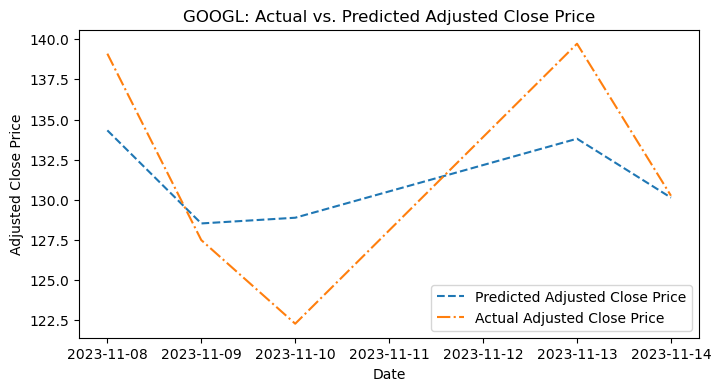

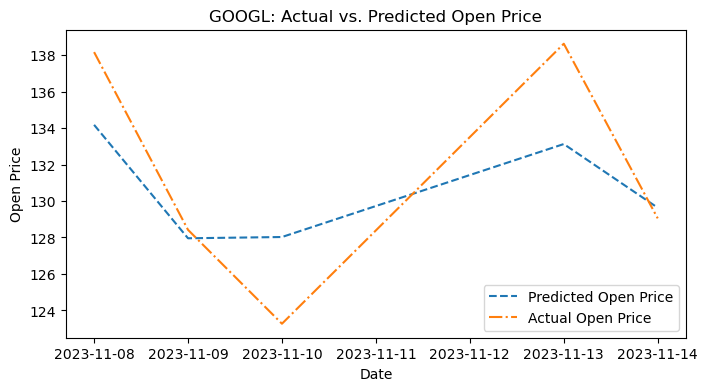


Results for GOOGL:
Mean Absolute Error (MAE_Adj_Close): 3.6898404834570444
Mean Squared Error (MSE_Adj_Close): 20.50025222588503
R-squared (R^2_Adj_Close): 0.5496833875221856
 
Mean Absolute Error (MAE_Open): 3.059178630976328
Mean Squared Error (MSE_Open): 13.877723459492008
R-squared (R^2_Open): 0.6113713987112137


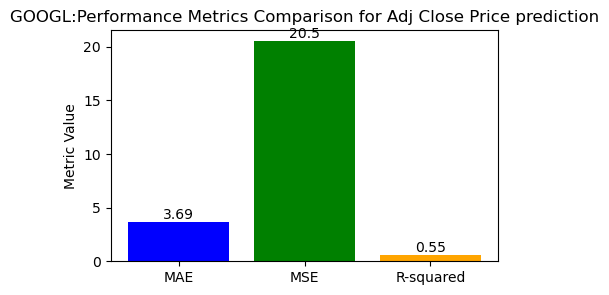

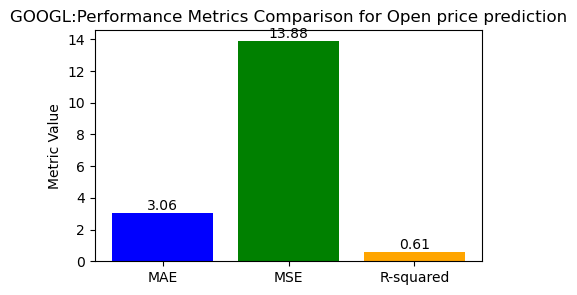

SVR Model saved as GOOGL_svr_models.pkl
[*********************100%%**********************]  1 of 1 completed


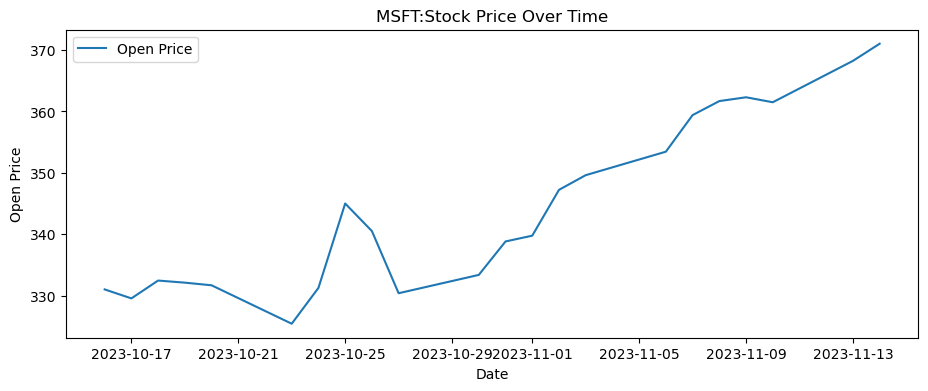

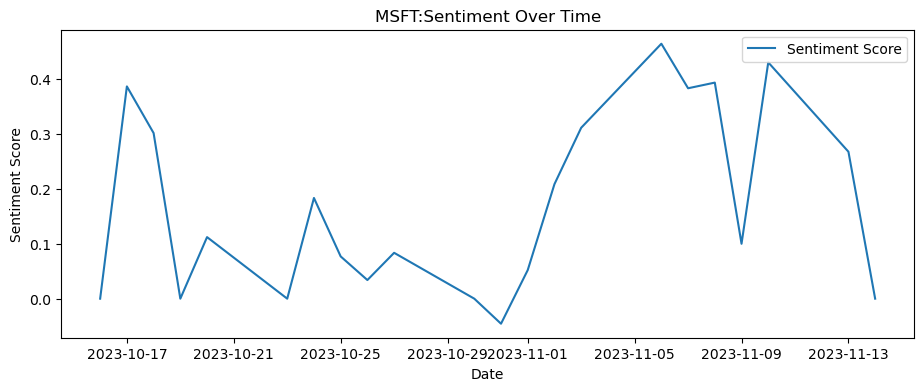

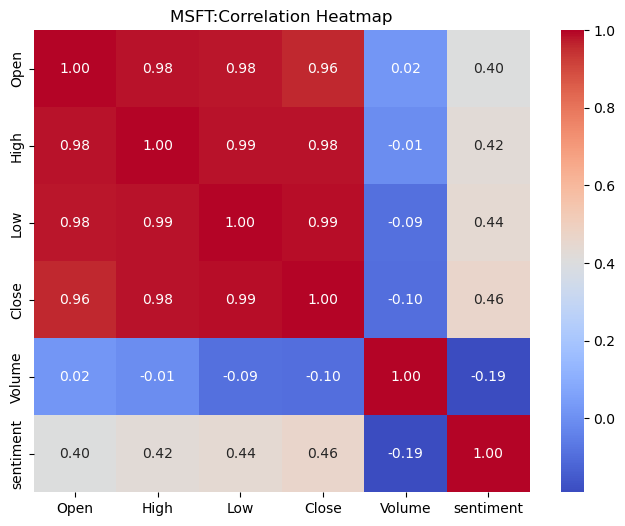

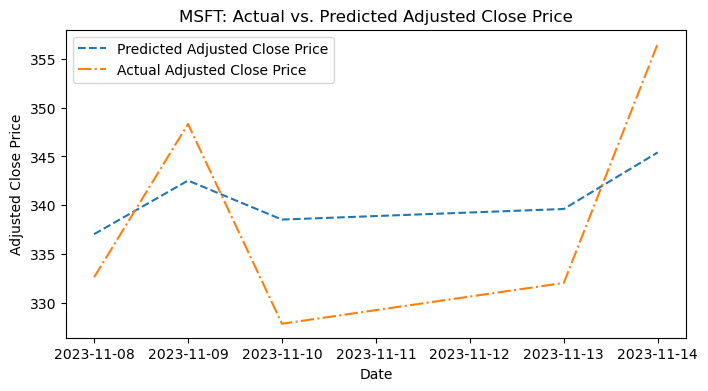

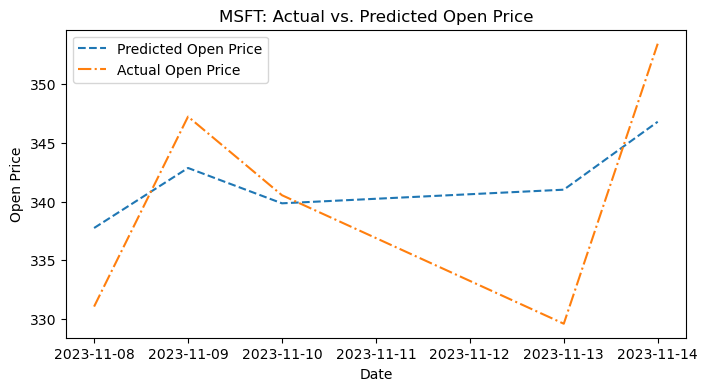


Results for MSFT:
Mean Absolute Error (MAE_Adj_Close): 7.905897583645617
Mean Squared Error (MSE_Adj_Close): 69.4404506012244
R-squared (R^2_Adj_Close): 0.4261285435894693
 
Mean Absolute Error (MAE_Open): 5.967030152099687
Mean Squared Error (MSE_Open): 47.83071084502639
R-squared (R^2_Open): 0.4324561766274717


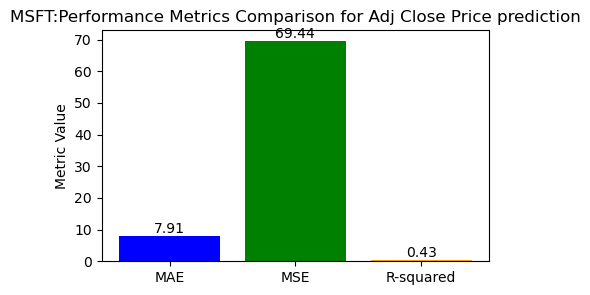

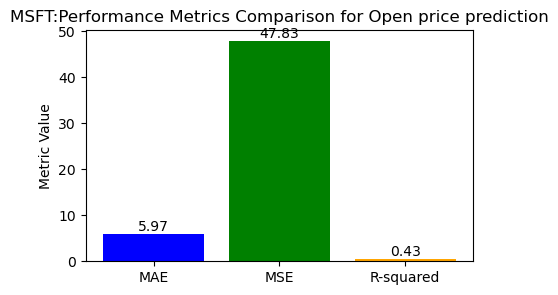

SVR Model saved as MSFT_svr_models.pkl


In [5]:
# Load and preprocess data

for ticker in company_tickers:
    
    stock_data = fetch_stock_data(ticker, start_date, end_date)
    news_data = fetch_news_data(news_api_key, ticker, start_date, end_date)
    merged_data = prepare_data(stock_data, news_data)
    
    # Time Series Plots
    plt.figure(figsize=(11, 4))
    plt.plot(merged_data.index, merged_data['Open'], label='Open Price')
    plt.title(f"{ticker}:Stock Price Over Time")
    plt.xlabel('Date')
    plt.ylabel('Open Price')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(11, 4))
    plt.plot(merged_data.index, merged_data['sentiment'], label='Sentiment Score')
    plt.title(f"{ticker}:Sentiment Over Time")
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.legend()
    plt.show()
    
    # Correlation Heatmap

    plt.figure(figsize=(8, 6))
    correlation_matrix = merged_data[['Open', 'High', 'Low', 'Close', 'Volume', 'sentiment']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f"{ticker}:Correlation Heatmap")
    plt.show()

    # Feature engineering and data splitting
    X = merged_data[['High', 'Low', 'Close', 'Volume', 'sentiment']]
    y1 = merged_data['Adj Close']
    y2 = merged_data['Open']
    
    X_train1, X_test1, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=42)
    X_train2, X_test2, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled1 = scaler.fit_transform(X_train1)
    X_test_scaled1 = scaler.transform(X_test1)

    X_train_scaled2 = scaler.fit_transform(X_train2)
    X_test_scaled2 = scaler.transform(X_test2)

    
    # Model building and training
    svr_model_Adj_Close = SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale')
    svr_model_Adj_Close.fit(X_train_scaled1, y1_train)

    svr_model_Open = SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale')
    svr_model_Open.fit(X_train_scaled2, y2_train)


    # Make predictions on the test data
    # Predictions and evaluations
    pred_Adj_Close = svr_model_Adj_Close.predict(X_test_scaled1)
    pred_Open = svr_model_Open.predict(X_test_scaled2)
    
    plt.figure(figsize=(8, 4))
    plt.plot(merged_data.index[-len(pred_Adj_Close):], pred_Adj_Close, label='Predicted Adjusted Close Price', linestyle='--')
    plt.plot(merged_data.index[-len(pred_Adj_Close):], y1_test.values, label='Actual Adjusted Close Price', linestyle='-.')
    plt.title(f"{ticker}: Actual vs. Predicted Adjusted Close Price")
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.show()


    plt.figure(figsize=(8, 4))
    plt.plot(merged_data.index[-len(pred_Open):], pred_Open, label='Predicted Open Price', linestyle='--')
    plt.plot(merged_data.index[-len(pred_Open):], y2_test.values, label='Actual Open Price', linestyle='-.')
    plt.title(f"{ticker}: Actual vs. Predicted Open Price")
    plt.xlabel('Date')
    plt.ylabel('Open Price')
    plt.legend()
    plt.show()

    mae1 = mean_absolute_error(y1_test.values.ravel(), pred_Adj_Close )
    mse1 = mean_squared_error(y1_test.values.ravel(), pred_Adj_Close )
    r21 = r2_score(y1_test.values.ravel(), pred_Adj_Close )

    mae2 = mean_absolute_error(y2_test.values.ravel(), pred_Open)
    mse2 = mean_squared_error(y2_test.values.ravel(), pred_Open)
    r22 = r2_score(y2_test.values.ravel(), pred_Open)

    print(f"\nResults for {ticker}:")
    print(f"Mean Absolute Error (MAE_Adj_Close): {mae1}")
    print(f"Mean Squared Error (MSE_Adj_Close): {mse1}")
    print(f"R-squared (R^2_Adj_Close): {r21}")
    print(" ")
    print(f"Mean Absolute Error (MAE_Open): {mae2}")
    print(f"Mean Squared Error (MSE_Open): {mse2}")
    print(f"R-squared (R^2_Open): {r22}")
    
    performance_metrics1 = {
        'MAE': mae1,
        'MSE': mse1,
        'R-squared': r21
    }
    performance_metrics2 = {
        'MAE': mae2,
        'MSE': mse2,
        'R-squared': r22
    }
    # Assuming performance_metrics1 and performance_metrics2 are dictionaries with metric names as keys and metric values as values

    # Plot for Adj Close Price prediction
    plt.figure(figsize=(5, 3))
    bars = plt.bar(performance_metrics1.keys(), performance_metrics1.values(), color=['blue', 'green', 'orange'])
    plt.title(f"{ticker}:Performance Metrics Comparison for Adj Close Price prediction")
    plt.ylabel('Metric Value')

    # Adding text annotations on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

    plt.show()

    # Plot for Open price prediction
    plt.figure(figsize=(5, 3))
    bars = plt.bar(performance_metrics2.keys(), performance_metrics2.values(), color=['blue', 'green', 'orange'])
    plt.title(f"{ticker}:Performance Metrics Comparison for Open price prediction")
    plt.ylabel('Metric Value')

    # Adding text annotations on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

    plt.show()

    
    # Build a pickle file of the model
    
    
    models_dict = {
    'svr_model_Adj_Close': svr_model_Adj_Close,
    'svr_model_Open': svr_model_Open
    }

    # Save the dictionary containing both models to a pickle file
    pickle_filename = f"{ticker}_svr_models.pkl"
    with open(pickle_filename, 'wb') as file:
        pickle.dump(models_dict, file)
    
    print(f"SVR Model saved as {pickle_filename}")

In [6]:
for ticker in company_tickers:

    stock_data = fetch_stock_data(ticker, start_date, end_date)
    news_data = fetch_news_data(news_api_key, ticker, start_date, end_date)
    merged_data = prepare_data(stock_data, news_data)
    
    # Feature engineering and data splitting
    X = merged_data[['High', 'Low', 'Close', 'Volume', 'sentiment']]
    y1 = merged_data['Adj Close']
    y2 = merged_data['Open']
    
    X_train1, X_test1, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=42)
    X_train2, X_test2, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled1 = scaler.fit_transform(X_train1)
    X_test_scaled1 = scaler.transform(X_test1)

    X_train_scaled2 = scaler.fit_transform(X_train2)
    X_test_scaled2 = scaler.transform(X_test2)
    pickle_filename = f"{ticker}_svr_models.pkl"
    
    
    
    with open(pickle_filename, 'rb') as file:
        loaded_models_dict = pickle.load(file)

    # Access the loaded models using their keys
    loaded_svr_model_Adj_Close = loaded_models_dict['svr_model_Adj_Close']
    loaded_svr_model_Open = loaded_models_dict['svr_model_Open']
    
    # Make predictions on the test data
    pred_Adj_Close_p = loaded_svr_model_Adj_Close.predict(X_test_scaled1)
    pred_Open_p = loaded_svr_model_Open.predict(X_test_scaled2)
    
    #evaluations
    mae1_p = mean_absolute_error(y1_test.values.ravel(), pred_Adj_Close_p )
    mse1_p = mean_squared_error(y1_test.values.ravel(), pred_Adj_Close_p )
    r21_p = r2_score(y1_test.values.ravel(), pred_Adj_Close_p )

    mae2_p = mean_absolute_error(y2_test.values.ravel(), pred_Open_p)
    mse2_p = mean_squared_error(y2_test.values.ravel(), pred_Open_p)
    r22_p = r2_score(y2_test.values.ravel(), pred_Open_p)

    print(f"\nResults for {ticker}:")
    print(f"Mean Absolute Error (MAE_Adj_Close): {mae1_p}")
    print(f"Mean Squared Error (MSE_Adj_Close): {mse1_p}")
    print(f"R-squared (R^2_Adj_Close): {r21_p}")
    print(" ")
    print(f"Mean Absolute Error (MAE_Open): {mae2_p}")
    print(f"Mean Squared Error (MSE_Open): {mse2_p}")
    print(f"R-squared (R^2_Open): {r22_p}")
    

[*********************100%%**********************]  1 of 1 completed

Results for AAPL:
Mean Absolute Error (MAE_Adj_Close): 2.5759622941023226
Mean Squared Error (MSE_Adj_Close): 13.663435743042873
R-squared (R^2_Adj_Close): 0.34497514093991166
 
Mean Absolute Error (MAE_Open): 1.170181897843446
Mean Squared Error (MSE_Open): 3.257534180124084
R-squared (R^2_Open): 0.4442388782611826
[*********************100%%**********************]  1 of 1 completed

Results for GOOGL:
Mean Absolute Error (MAE_Adj_Close): 3.6898404834570444
Mean Squared Error (MSE_Adj_Close): 20.50025222588503
R-squared (R^2_Adj_Close): 0.5496833875221856
 
Mean Absolute Error (MAE_Open): 3.059178630976328
Mean Squared Error (MSE_Open): 13.877723459492008
R-squared (R^2_Open): 0.6113713987112137
[*********************100%%**********************]  1 of 1 completed

Results for MSFT:
Mean Absolute Error (MAE_Adj_Close): 7.905897583645617
Mean Squared Error (MSE_Adj_Close): 69.4404506012244
R-squared (R^2_Adj_Close): 0